In [1]:
from pyspark.sql import SparkSession
import pandas as pd
# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 10)
spark = SparkSession.builder.appName('Big_data_project').getOrCreate()
df= spark.read.csv(r"C:\Users\Karthik\Downloads\customer_churn.csv", header = True, inferSchema = True)
df.cache()

DataFrame[customerID: string, gender: string, SeniorCitizen: int, Partner: string, Dependents: string, tenure: int, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, MonthlyCharges: double, TotalCharges: double, Churn: string]

About the data

In [3]:
print ("Rows     : " ,df.count())
print ("Columns  : " ,len(df.columns))
print ("\nFeatures : \n" ,df.columns)
print("")
print("Number of class in the dataset: ",df.select(F.countDistinct("Churn")).collect())
df.printSchema()
#First three rows of data
print(pd.DataFrame(df.take(3), columns=df.columns).transpose())
print("")
print(df.dtypes)
#df.cache()

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Number of class in the dataset:  [Row(count(DISTINCT Churn)=2)]
root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = tru

finding missing values and dropping those rows

In [4]:
print(df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().transpose())
df = df.where(df["TotalCharges"].isNotNull())
print("")
print("After dropping rows with null values")
print(df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().transpose())


                   0
customerID         0
gender             0
SeniorCitizen      0
Partner            0
Dependents         0
tenure             0
PhoneService       0
MultipleLines      0
InternetService    0
OnlineSecurity     0
OnlineBackup       0
DeviceProtection   0
TechSupport        0
StreamingTV        0
StreamingMovies    0
Contract           0
PaperlessBilling   0
PaymentMethod      0
MonthlyCharges     0
TotalCharges      11
Churn              0

After dropping rows with null values
                  0
customerID        0
gender            0
SeniorCitizen     0
Partner           0
Dependents        0
tenure            0
PhoneService      0
MultipleLines     0
InternetService   0
OnlineSecurity    0
OnlineBackup      0
DeviceProtection  0
TechSupport       0
StreamingTV       0
StreamingMovies   0
Contract          0
PaperlessBilling  0
PaymentMethod     0
MonthlyCharges    0
TotalCharges      0
Churn             0


In [5]:
#summary statistics
print(df.describe().toPandas().transpose())


                      0                    1                   2                          3             4
summary           count                 mean              stddev                        min           max
customerID         7032                 None                None                 0002-ORFBO    9995-HOTOH
gender             7032                 None                None                     Female          Male
SeniorCitizen      7032  0.16240045506257111  0.3688439967571055                          0             1
Partner            7032                 None                None                         No           Yes
Dependents         7032                 None                None                         No           Yes
tenure             7032   32.421786120591584  24.545259709263245                          1            72
PhoneService       7032                 None                None                         No           Yes
MultipleLines      7032                 None  

"Data Manipulation"

In [6]:
#dropping unwanted columns from the dataframe.
df = df.drop('customerID')
# replace 'No internet service' to No for the following columns
cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in cols:
    df = df.withColumn(col, F.when(df[col]=='No internet service','No').otherwise(df[col]))
#replace values of SeniorCitizen to stringtype
df = df.withColumn("SeniorCitizen", df["SeniorCitizen"].cast(StringType()))

#df = df.withColumn('SeniorCitizen', F.when(df["SeniorCitizen"]== '0', "Yes").otherwise(df["SeniorCitizen"]))
df = df.replace(['1','0'],['Yes','No'],'SeniorCitizen')

In [7]:
# Converting attribute Tenure to categorical column
def tenure_lab(r):
    if r <= 12:
        return "Tenure_0-12"
    elif (r > 12) & (r <= 24):
        return "Tenure_12-24"
    elif (r > 24) & (r <= 48):
        return "Tenure_24-48"
    elif (r > 48) & (r <= 60):
        return "Tenure_48-60"
    elif r > 60:
        return "Tenure_gt_60"

ol_val = udf(tenure_lab, StringType())

df = df.withColumn("tenureGroup",F.lit(ol_val(df.tenure)))


In [8]:

#target column identification
target_col = df["Churn"]
print("Target column is ",target_col)
drptar = df.drop("Churn")

Target column is  Column<b'Churn'>


In [9]:
print(pd.DataFrame(df.take(3), columns=df.columns).transpose())

                                 0             1               2
gender                      Female          Male            Male
SeniorCitizen                   No            No              No
Partner                        Yes            No              No
Dependents                      No            No              No
tenure                           1            34               2
PhoneService                    No           Yes             Yes
MultipleLines     No phone service            No              No
InternetService                DSL           DSL             DSL
OnlineSecurity                  No           Yes             Yes
OnlineBackup                   Yes            No             Yes
DeviceProtection                No           Yes              No
TechSupport                     No            No              No
StreamingTV                     No            No              No
StreamingMovies                 No            No              No
Contract            Month

Separating numerical and categorical columns for preprocessing purpose

In [10]:
num_cols = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
#num_cols = df._get_numeric_data().columns
print("numerical columns: ",num_cols)
cat_cols = [t[0] for t in drptar.dtypes if t[1] == 'string']
print("categorical columns: ",cat_cols)

numerical columns:  ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical columns:  ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenureGroup']


Data Exploration

In [11]:
pdf = df.toPandas()
#Separating churn and non churn customers
churn = pdf[pdf["Churn"] == "Yes"]
not_churn = pdf[pdf["Churn"] == "No"]
target_column = ["Churn"]
categ_cols   = pdf.nunique()[pdf.nunique() < 6].keys().tolist()
categ_cols   = [x for x in categ_cols if x not in target_column]
numeric_cols = [x for x in pdf.columns if x not in categ_cols + target_column]


In [12]:
import matplotlib.font_manager
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from matplotlib import rcParams



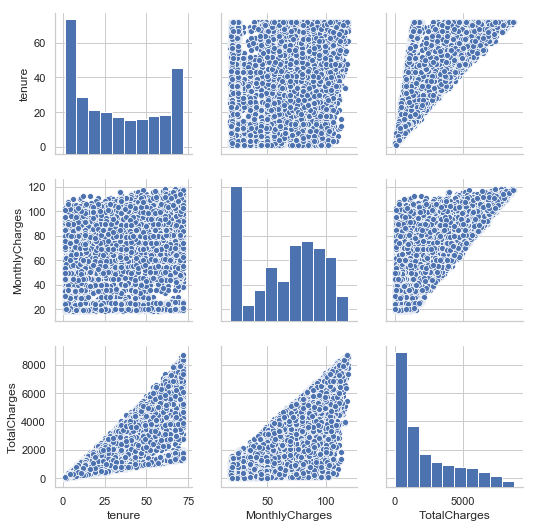

In [13]:
sns.set(style='whitegrid',context='notebook')
cols=['tenure', 'MonthlyCharges', 'TotalCharges','Churn']
sns.pairplot(pdf[cols],height=2.5)
plt.show()


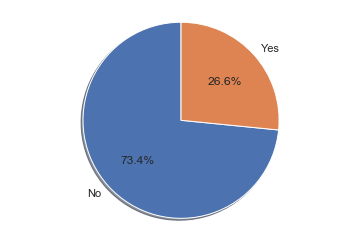

In [14]:
#labels
lab = pdf["Churn"].value_counts().keys().tolist()
#values
val = pdf["Churn"].value_counts().values.tolist()
fig1, ax1 = plt.subplots()
ax1.pie(val,  labels=lab, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


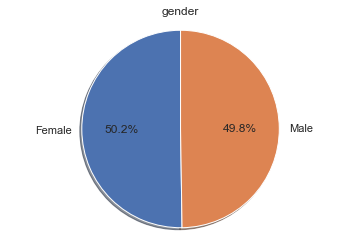

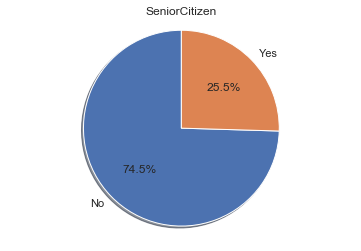

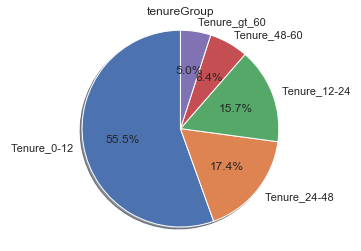

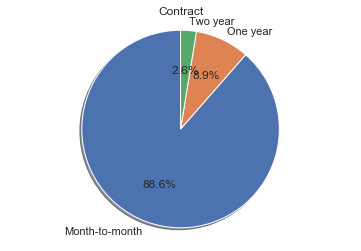

In [15]:
#Churn customers distribution with respect to selected categorical data
def plot_pie(column):
    val = churn[column].value_counts().values.tolist()
    lab  = churn[column].value_counts().keys().tolist()
    fig1, ax1 = plt.subplots()
    ax1.pie(val,  labels=lab, autopct='%1.1f%%',shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(column)
    plt.show()

categorical_columns = ['gender', 'SeniorCitizen', 'tenureGroup','Contract']
for i in categorical_columns :
    plot_pie(i)




   

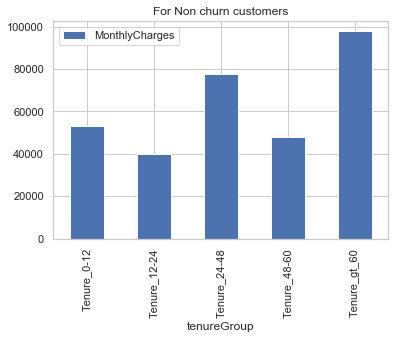

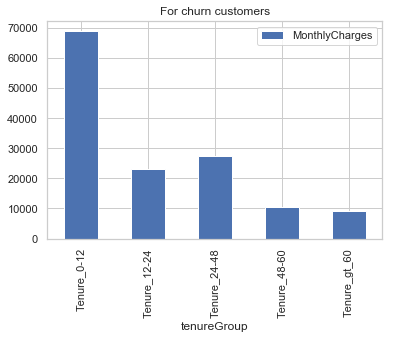

In [16]:
newpdf = pdf[['MonthlyCharges','Churn','tenureGroup']]
newpdf[newpdf.Churn == "No"].groupby(['tenureGroup']).sum().plot(kind='bar',title = 'For Non churn customers')
newpdf[newpdf.Churn == "Yes"].groupby(['tenureGroup']).sum().plot(kind='bar',title = 'For churn customers')

Data Preprocessing using StringIndexer, OneHotEncoder and VectorAssembler.  First the input categorical columns are indexed using stringIndexer and then converted to corresponding numeric category using OneHotEncoderEstimator and assembled into a vector dataframe format using Vector Assembler.

In [17]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import OneHotEncoderEstimator
categoricalColumns = cat_cols
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'Churn', outputCol = 'label')
stages += [label_stringIdx]
#numericCols = ['tenure', 'MonthlyCharges', 'TotalCharges']
numericCols = num_cols
assemblerInputs = [a + "classVec" for a in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


Creating a pipeline to organize the transformations and preprocessing steps

In [18]:
columns = df.columns
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + columns
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)
 |-- tenureGroup: string (nullable = true)



In [19]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0,0,1,0,1
features,"(0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","(1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ..."
gender,Female,Male,Male,Male,Female
SeniorCitizen,No,No,No,No,No
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic



    Model Selection

In [20]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

train, test = df.randomSplit([0.8, 0.2], seed=12345)

LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter = 10)

#We use a ParamGridBuilder to construct a grid of parameters to search over.
paramGrid = (ParamGridBuilder().addGrid(LR.regParam, [0.01, 0.5, 2.0, 0.1, 0.01]).addGrid(LR.elasticNetParam, [0.0, 0.5, 1.0]).build())

cv = CrossValidator(estimator=LR,estimatorParamMaps=paramGrid,evaluator=BinaryClassificationEvaluator(),numFolds=4)

cvModel = cv.fit(train)

In [21]:
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))
LRmodel = LR.fit(train)



Training Dataset Count: 5601
Test Dataset Count: 1431


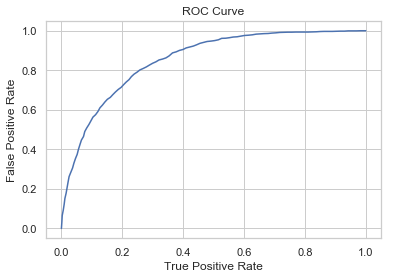

Training accuracy: 0.8520013142707904


In [22]:
#Summarizing model on training data and obtaining the receiver-operating characteristic and areaUnderROC.
trainingSummary = LRmodel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training accuracy: ' + str(trainingSummary.areaUnderROC))


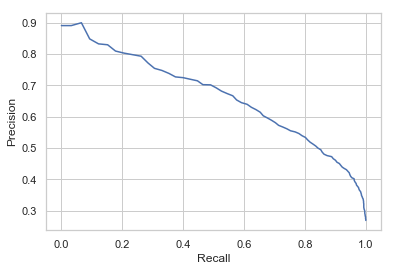

In [23]:
#Precision and recall.

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [24]:
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
LR.setThreshold(bestThreshold)
LRmodel = LR.fit(train)

In [25]:
# Make predictions on the test set.

predictions = LRmodel.transform(test)
Train_predictions = LRmodel.transform(train)
a = predictions.select('SeniorCitizen','gender','tenureGroup','MonthlyCharges', 'Churn', 'prediction', 'probability').show(10)
#a.filter(a.Churn == 'No').show(100)


+-------------+------+------------+--------------+-----+----------+--------------------+
|SeniorCitizen|gender| tenureGroup|MonthlyCharges|Churn|prediction|         probability|
+-------------+------+------------+--------------+-----+----------+--------------------+
|           No|  Male|Tenure_24-48|          94.2|   No|       1.0|[0.52523045721995...|
|           No|  Male|Tenure_48-60|          83.8|   No|       0.0|[0.71615728453110...|
|           No|  Male| Tenure_0-12|         86.05|   No|       1.0|[0.30238084685657...|
|           No|  Male| Tenure_0-12|          90.4|   No|       1.0|[0.29702009901789...|
|           No|  Male|Tenure_24-48|          91.0|   No|       1.0|[0.64412401624893...|
|           No|  Male| Tenure_0-12|         89.85|   No|       1.0|[0.33400468421398...|
|           No|  Male|Tenure_24-48|         89.65|   No|       0.0|[0.72850979401233...|
|           No|  Male|Tenure_gt_60|          79.6|   No|       0.0|[0.93821816330159...|
|           No|  Male

In [26]:
#Evaluate our Logistic Regression model.

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()

print('Training accuracy: ' + str(evaluator.evaluate(Train_predictions, {evaluator.metricName: "areaUnderROC"})))
print('Test Accuracy :', evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))


Training accuracy: 0.8521374073999581
Test Accuracy : 0.8224920392471532


predictions = cvModel.transform(test)
Train_predictions = cvModel.transform(train)
print('Training accuracy: ' + str(evaluator.evaluate(Train_predictions, {evaluator.metricName: "areaUnderROC"})))
print('Test Accuracy :', evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))


Findings: Logistic Regression model created using cross validation seems slightly better in terms of test accuracy and generalization.

Decision Tree classifier

In [27]:
from pyspark.ml.classification import DecisionTreeClassifier
DT = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
DTmodel = DT.fit(train)
predictions = DTmodel.transform(test)
Train_predictions = DTmodel.transform(train)
evaluator = BinaryClassificationEvaluator()
print('Training accuracy: ' + str(evaluator.evaluate(Train_predictions, {evaluator.metricName: "areaUnderROC"})))
print("Test Accuracy: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Training accuracy: 0.8273725082806188
Test Accuracy: 0.7815439977218008


To reduce overfitting of training data, the maximum depth is cut to 3 where test accuracy is good.

In [28]:
from pyspark.ml.classification import RandomForestClassifier
RF = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees = 10, seed = 12345678)
RFmodel = RF.fit(train)
predictions = RFmodel.transform(test)
Train_predictions = RFmodel.transform(train)
evaluator = BinaryClassificationEvaluator()
print('Training accuracy: ' + str(evaluator.evaluate(Train_predictions, {evaluator.metricName: "areaUnderROC"})))
print("Test Accuracy: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Training accuracy: 0.8585026774703053
Test Accuracy: 0.8224402619929043


In [29]:
from pyspark.ml.classification import GBTClassifier
GBT = GBTClassifier(featuresCol = 'features', labelCol = 'label',maxIter=10, seed = 12345)
GBTmodel = GBT.fit(train)
predictions = GBTmodel.transform(test)
Train_predictions = GBTmodel.transform(train)
evaluator = BinaryClassificationEvaluator()
print('Training accuracy: ' + str(evaluator.evaluate(Train_predictions, {evaluator.metricName: "areaUnderROC"})))
print("Test Accuracy: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))


Training accuracy: 0.8767585176477177
Test Accuracy: 0.8163629067750533


Among this Random forest gives most robust test accuracy.  So, it is chosen as our model for this dataset.

#performing model tuning using CrossValidator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(RF.maxDepth, [2,3, 4,5, 6])
             .addGrid(RF.numTrees, [10, 20])
             .build())
cv = CrossValidator(estimator=RF, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
#Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

Feature Selection for improving accuracy, reducing overfitting and reducing training time.

In [31]:
RFmodel.featureImportances

SparseVector(28, {0: 0.0013, 1: 0.0057, 2: 0.0003, 3: 0.0026, 4: 0.0004, 5: 0.0032, 6: 0.0068, 7: 0.139, 8: 0.0321, 9: 0.011, 10: 0.0033, 11: 0.001, 12: 0.0095, 13: 0.008, 14: 0.0083, 15: 0.1952, 16: 0.0293, 17: 0.0272, 18: 0.0579, 19: 0.0023, 20: 0.0037, 21: 0.0487, 22: 0.0018, 23: 0.0147, 24: 0.0017, 25: 0.2392, 26: 0.0826, 27: 0.0632})

In [32]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [33]:
ExtractFeatureImp(RFmodel.featureImportances, df, "features").head(10)

,idx,name,score
0,25,tenure,0.239202
18,15,ContractclassVec_Month-to-month,0.195230
10,7,InternetServiceclassVec_Fiber optic,0.138974
1,26,MonthlyCharges,0.082606
2,27,TotalCharges,0.063231
21,18,PaymentMethodclassVec_Electronic check,0.057903
24,21,tenureGroupclassVec_Tenure_0-12,0.048745
11,8,InternetServiceclassVec_DSL,0.032057
19,16,ContractclassVec_Two year,0.029300
20,17,PaperlessBillingclassVec_Yes,0.027223


Now we have the top ten important features in a formatted list.  With only these 10 features we can build a more effective model.  This feature selection process will help our model to attain high accuracy, reduced training time and escape from the problem of overfitting.

VectorSlicer function is used to select only the top 10 important features.



In [34]:
varlist = ExtractFeatureImp(RFmodel.featureImportances, df, "features")

In [35]:
varidx = [x for x in varlist['idx'][0:10]]

In [36]:
varidx

[25, 15, 7, 26, 27, 18, 21, 8, 16, 17]

In [37]:
from pyspark.ml.feature import VectorSlicer
slicer = VectorSlicer(inputCol="features", outputCol="features2", indices=varidx)
df1 = slicer.transform(df)

In [38]:
df1.select("features","features2").show()

+--------------------+--------------------+
|            features|           features2|
+--------------------+--------------------+
|(28,[1,3,8,9,11,1...|(10,[0,1,3,4,5,6,...|
|(28,[0,1,2,3,4,5,...|(10,[0,3,4,7],[34...|
|[1.0,1.0,1.0,1.0,...|[2.0,1.0,0.0,53.8...|
|(28,[0,1,2,3,8,10...|(10,[0,3,4,7],[45...|
|[0.0,1.0,1.0,1.0,...|[2.0,1.0,1.0,70.7...|
|(28,[1,2,3,4,6,7,...|(10,[0,1,2,3,4,5,...|
|(28,[0,1,2,4,6,7,...|(10,[0,1,2,3,4,9]...|
|(28,[1,2,3,8,10,1...|(10,[0,1,3,4,6,7]...|
|(28,[1,3,4,6,7,9,...|(10,[0,1,2,3,4,5,...|
|(28,[0,1,2,4,5,8,...|(10,[0,3,4,7],[62...|
|(28,[0,1,4,5,8,10...|(10,[0,1,3,4,7,9]...|
|(28,[0,1,2,3,4,5,...|(10,[0,3,4,8],[16...|
|(28,[0,1,3,4,6,7,...|(10,[0,2,3,4],[58...|
|(28,[0,1,2,3,4,6,...|(10,[0,1,2,3,4,9]...|
|(28,[0,1,2,3,4,5,...|(10,[0,1,2,3,4,5,...|
|(28,[1,4,6,7,16,2...|(10,[0,2,3,4,8],[...|
|(28,[1,2,3,4,5,9,...|(10,[0,3,4],[52.0...|
|(28,[0,1,2,4,6,7,...|(10,[0,2,3,4,8],[...|
|(28,[1,4,5,8,9,10...|(10,[0,1,3,4,6,7]...|
|(28,[1,2,3,4,5,7,...|(10,[0,1,2

From above it is clear that only 10 features selected from 28 feature combinations.

In [39]:
df1 = df1.drop('rawPrediction', 'probability', 'prediction')
RF2 = RandomForestClassifier(labelCol="label", featuresCol="features2", seed = 1234,
                            numTrees=10, cacheNodeIds = True, subsamplingRate = 0.7)
RFmodel2 = RF2.fit(df1)
df4 = RFmodel2.transform(df1)

In [40]:
train, test = df1.randomSplit([0.8, 0.2], seed=1234)

In [41]:
RFmodel2 = RF.fit(train)
predictions = RFmodel2.transform(test)
Train_predictions = RFmodel2.transform(train)
evaluator = BinaryClassificationEvaluator()
print('Training accuracy: ' + str(evaluator.evaluate(Train_predictions, {evaluator.metricName: "areaUnderROC"})))
print("Test Accuracy: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Training accuracy: 0.8561567322547292
Test Accuracy: 0.8369218500797436


In [42]:
#performing model tuning using CrossValidator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(RF.maxDepth, [2,3, 4,5, 6])
             .addGrid(RF.numTrees, [10, 20])
             .build())
cv = CrossValidator(estimator=RF, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
#Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8403644285997217

Now we can see the test accuracy have improved.

In [43]:
# For ROC Curve of the designed model
results = predictions.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]




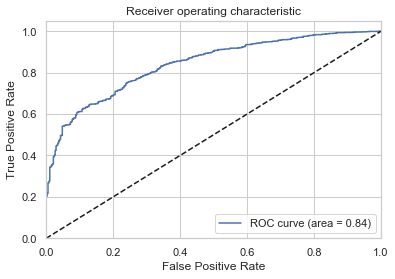

In [44]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [45]:
df.unpersist()

DataFrame[label: double, features: vector, gender: string, SeniorCitizen: string, Partner: string, Dependents: string, tenure: int, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, MonthlyCharges: double, TotalCharges: double, Churn: string, tenureGroup: string]